# Model comparison using MNIST

Shun Li, 03/07/24

## Initialize and load dataset

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from EPLHb import EPLHb, gd, adam

import numpy as np
from scipy import stats
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
# Downloading MNIST data

train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

# Loading the data
batch_size = 100 # the size of input data took for one iteration

train_loader = torch.utils.data.DataLoader(dataset = train_data,batch_size = batch_size,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = batch_size,shuffle = False)

## Models to be tested

Different initialization scenarios
- random initialization of every synapses
- Dale's law initialization of every synapses

Different network structure
- LHb to DAN is all inhibitory + LHb to LHb is all excitatory (if RNN)
- Every layer have mixed excitatory/inhibitory output

Different update methods
- Normal ADAM
- Fixed sign ADAM

In [3]:
LHb_network = ['MLP','RNN']

initialization = ['random','dales_law']
network_struct = ['real','mixed']
update_methods = ['corelease','fixed_sign']

In [4]:
EP_size = 784 # img_size = (28,28) ---> 28*28=784 in total
LHb_size = 500 # number of nodes at hidden layer
DAN_size = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
lr = 1e-3 # size of step

prob_EP_to_LHb = 1
prob_LHb_to_LHb = 1
prob_LHb_to_DAN = 1

n_networks = 20 # number of networks to train

## Train models

In [5]:
training_loss_summary, test_accuracy_summary = {}, {}

for LHb in LHb_network:
    for init in initialization:
        for struct in network_struct:
            for method in update_methods:
                print('LHb: ',LHb, '; Initialization:',init,'; Network:',struct,'; Method:',method)
                
                # Initialize network-specific loss and accuracy summary
                network_training_loss, network_test_accuracy = [], []

                # Initialize network params
                if LHb == 'MLP': rnn = False
                else: rnn = True
                if init == 'random': fixed_sign_init = False
                else: fixed_sign_init = True
                if struct == 'real': real_circuit = True
                else: real_circuit = False
                if method == 'corelease': fixed_sign_update = False
                else: fixed_sign_update = True

                # Train n_networks networks
                for i in range(1,n_networks+1):
                    # Initialize a network
                    net = EPLHb(EP_size,LHb_size,DAN_size,
                                rnn=rnn,fixed_sign=fixed_sign_init,real_circuit=real_circuit,
                                prob_EP_to_LHb=prob_EP_to_LHb,prob_LHb_to_LHb=prob_LHb_to_LHb,prob_LHb_to_DAN=prob_LHb_to_DAN)
                    initial_params = net.record_params(calc_sign=False)
                    training_loss, test_accuracy = [], []
                    if torch.cuda.is_available(): net.cuda()

                    # Train on original data
                    optimizer = adam(net.parameters(), lr=lr, fixed_sign=fixed_sign_update)
                    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
                    training_loss, test_accuracy = net.train_model(num_epochs,train_loader,optimizer,
                                                    test_loader=test_loader,print_epoch=False,loss='CrossEntropyLoss')
                    training_loss.extend(training_loss)
                    test_accuracy.extend(test_accuracy)

                    # Train on flipped data
                    # optimizer = adam(net.parameters(), lr=lr, fixed_sign=fixed_sign_update)
                    # training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
                    # net_training_loss.extend(training_loss)

                    network_training_loss.append(training_loss)
                    network_test_accuracy.append(test_accuracy)
                    print('Finished training network %d/%d' %(i,n_networks))

                # Convert list to numpy array
                network_training_loss = np.array(network_training_loss)
                network_test_accuracy = np.array(network_test_accuracy)

                # Store name and stats of network to summary
                network_name = LHb+'_'+init+'_'+struct+'_'+method
                training_loss_summary[network_name] = network_training_loss
                test_accuracy_summary[network_name] = network_test_accuracy

LHb:  MLP ; Initialization: random ; Network: real ; Method: corelease
Finished training network 1/20
Finished training network 2/20
Finished training network 3/20
Finished training network 4/20
Finished training network 5/20
Finished training network 6/20
Finished training network 7/20
Finished training network 8/20
Finished training network 9/20
Finished training network 10/20
Finished training network 11/20
Finished training network 12/20
Finished training network 13/20
Finished training network 14/20
Finished training network 15/20
Finished training network 16/20
Finished training network 17/20
Finished training network 18/20
Finished training network 19/20
Finished training network 20/20
LHb:  MLP ; Initialization: random ; Network: real ; Method: fixed_sign
Finished training network 1/20
Finished training network 2/20
Finished training network 3/20
Finished training network 4/20
Finished training network 5/20
Finished training network 6/20
Finished training network 7/20
Finished 

In [ ]:
# Save as pickle file
from datetime import date

today = date.today()
filename = 'Results/model_comparison_'+today.strftime("%Y%m%d")+'.pkl'
print('Saving to',filename)

with open(filename, 'wb') as f:
    data = [training_loss_summary, test_accuracy_summary]
    pickle.dump(data, f)

print('Done')

Saving to Results/model_comparison_20240307.pkl
Done


## Summary analysis

In [ ]:
# Optinal: load pickle file
# with open('model_comparison.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)

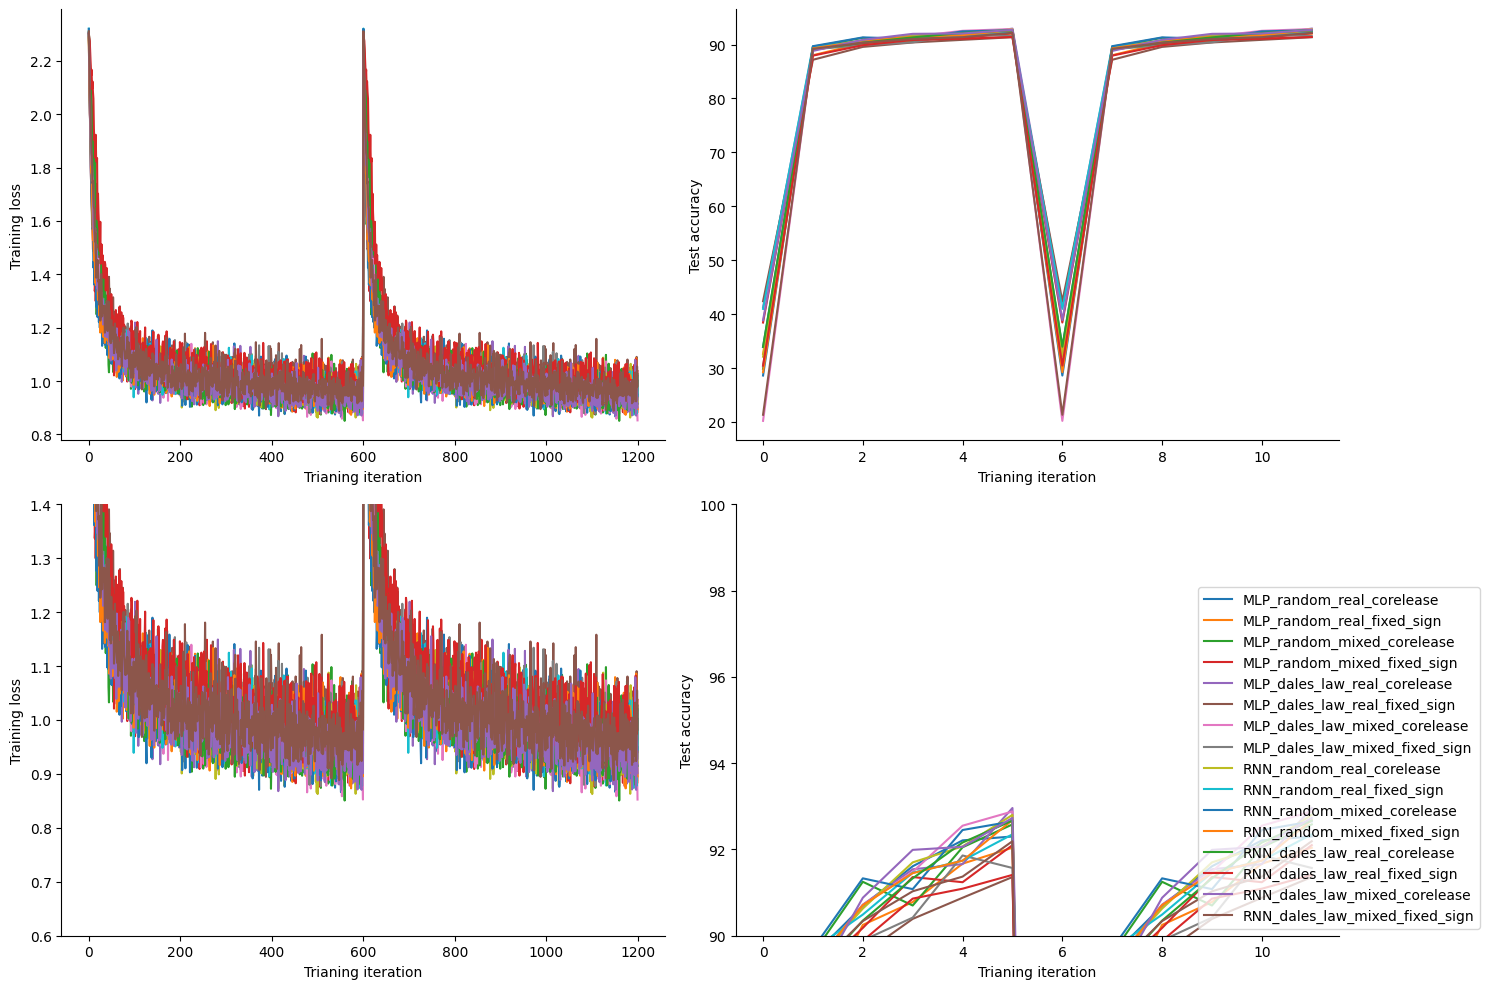

In [ ]:
# Plot loss and accuracy for each network

fig, axs = plt.subplots(2,2,figsize=(15, 10))

for network in training_loss_summary:
    # print(network)
    mean_loss = np.mean(training_loss_summary[network],axis=0)
    sem_loss = stats.sem(training_loss_summary[network])
    mean_acc = np.mean(test_accuracy_summary[network],axis=0)
    sem_acc = stats.sem(test_accuracy_summary[network])

    x = np.linspace(1,mean_loss.shape[0],num=mean_loss.shape[0],dtype='int32')
    axs[0,0].plot(mean_loss, label=network)
    axs[0,0].fill_between(x,mean_loss+sem_loss,mean_loss-sem_loss,alpha=0.2)
    axs[0,0].set_xlabel('Trianing iteration')
    axs[0,0].set_ylabel('Training loss')
    # axs[0,0].legend()

    axs[1,0].plot(mean_loss, label=network)
    axs[1,0].fill_between(x,mean_loss+sem_loss,mean_loss-sem_loss,alpha=0.2)
    axs[1,0].set_xlabel('Trianing iteration')
    axs[1,0].set_ylabel('Training loss')
    axs[1,0].set_ylim([0.6, 1.4])
    # axs[1,0].legend()

    # Plot accuracy
    x = np.linspace(1,mean_acc.shape[0]*100,num=mean_acc.shape[0],dtype='int32')
    axs[0,1].plot(mean_acc, label=network)
    axs[0,1].fill_between(x,mean_acc+sem_acc,mean_acc-sem_acc,alpha=0.2)
    axs[0,1].set_xlabel('Trianing iteration')
    axs[0,1].set_ylabel('Test accuracy')
    # axs[0,1].legend()

    axs[1,1].plot(mean_acc, label=network)
    axs[1,1].fill_between(x,mean_acc+sem_acc,mean_acc-sem_acc,alpha=0.2)
    axs[1,1].set_xlabel('Trianing iteration')
    axs[1,1].set_ylabel('Test accuracy')
    axs[1,1].set_ylim([90, 100])
    # axs[1,1].legend()


plt.legend(bbox_to_anchor=(1, 0), loc='lower center', ncol=len(training_loss_summary)/16)
plt.show()
    

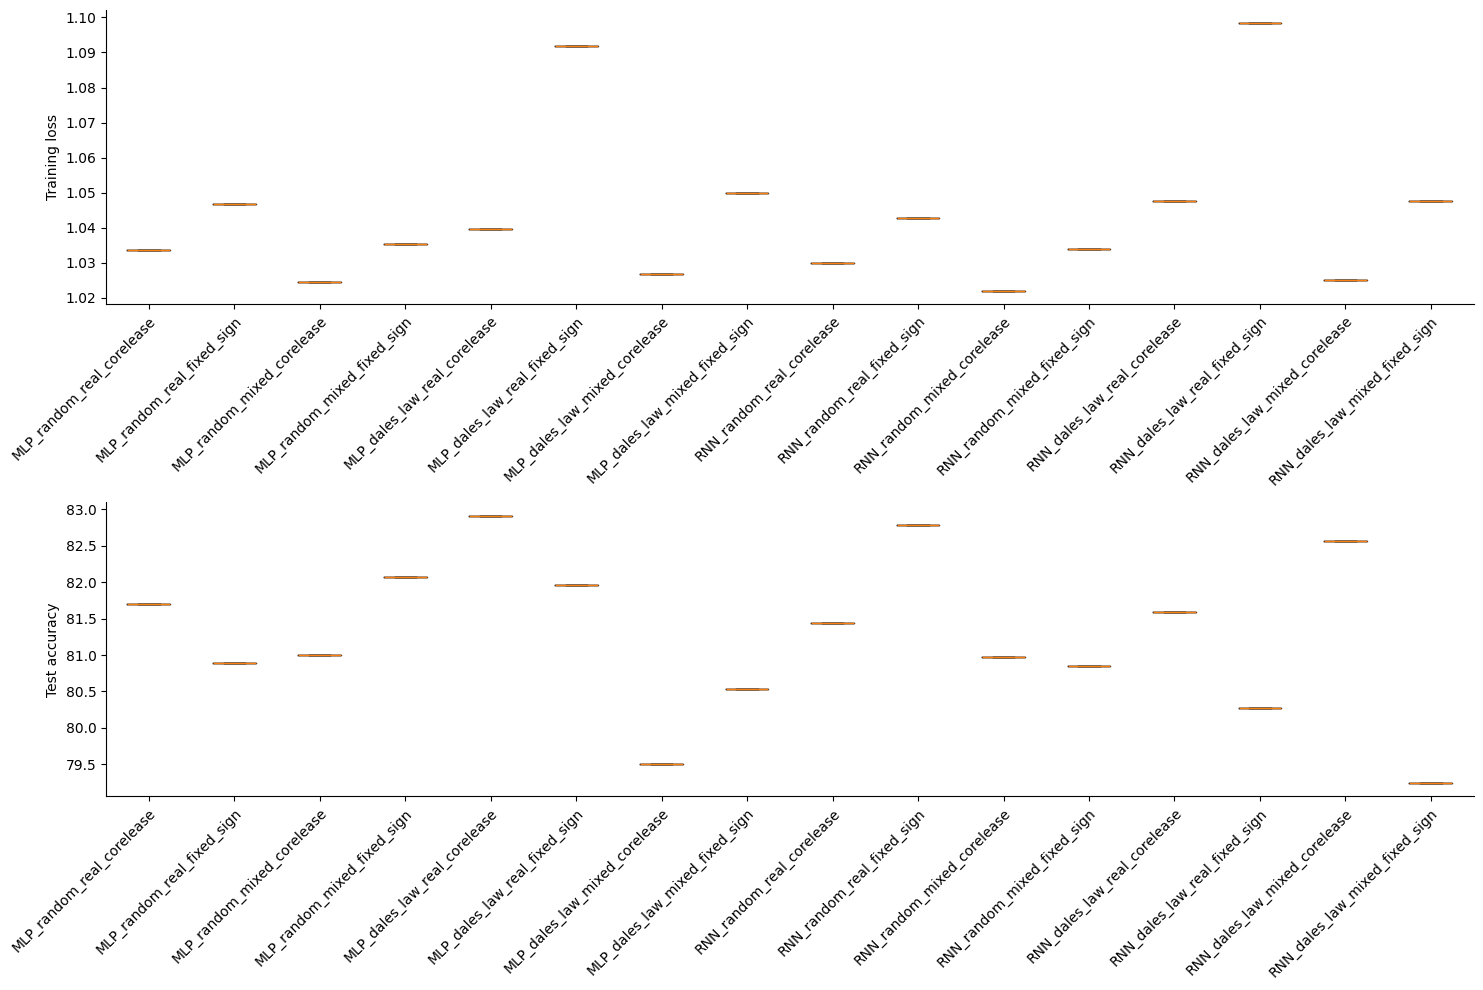

In [ ]:
# Plot bar plots of different conditions

fig, axs = plt.subplots(2,1,figsize=(15, 10))

# Plot loss
mean_loss = []
sem_loss = []
for network in training_loss_summary:
    mean_loss.append(np.mean(training_loss_summary[network],axis=1))
    # sem_loss.extend(stats.sem(training_loss_summary[network],axis=1))

axs[0].boxplot(mean_loss,positions=np.arange(len(mean_loss)))
axs[0].set_xticks(x)
axs[0].set_xticklabels(training_loss_summary.keys())
axs[0].set_ylabel('Training loss')
# Rotate the tick labels and set their alignment.
plt.setp(axs[0].get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Plot accuracy
mean_acc = []
sem_acc = []
for network in test_accuracy_summary:
    mean_acc.append(np.mean(test_accuracy_summary[network],axis=1))
    # sem_acc.extend(stats.sem(test_accuracy_summary[network],axis=1))

axs[1].boxplot(mean_acc,positions=np.arange(len(mean_acc)))
axs[1].set_xticks(x)
axs[1].set_xticklabels(test_accuracy_summary.keys())
axs[1].set_ylabel('Test accuracy')
# Rotate the tick labels and set their alignment.
plt.setp(axs[1].get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
plt.show()


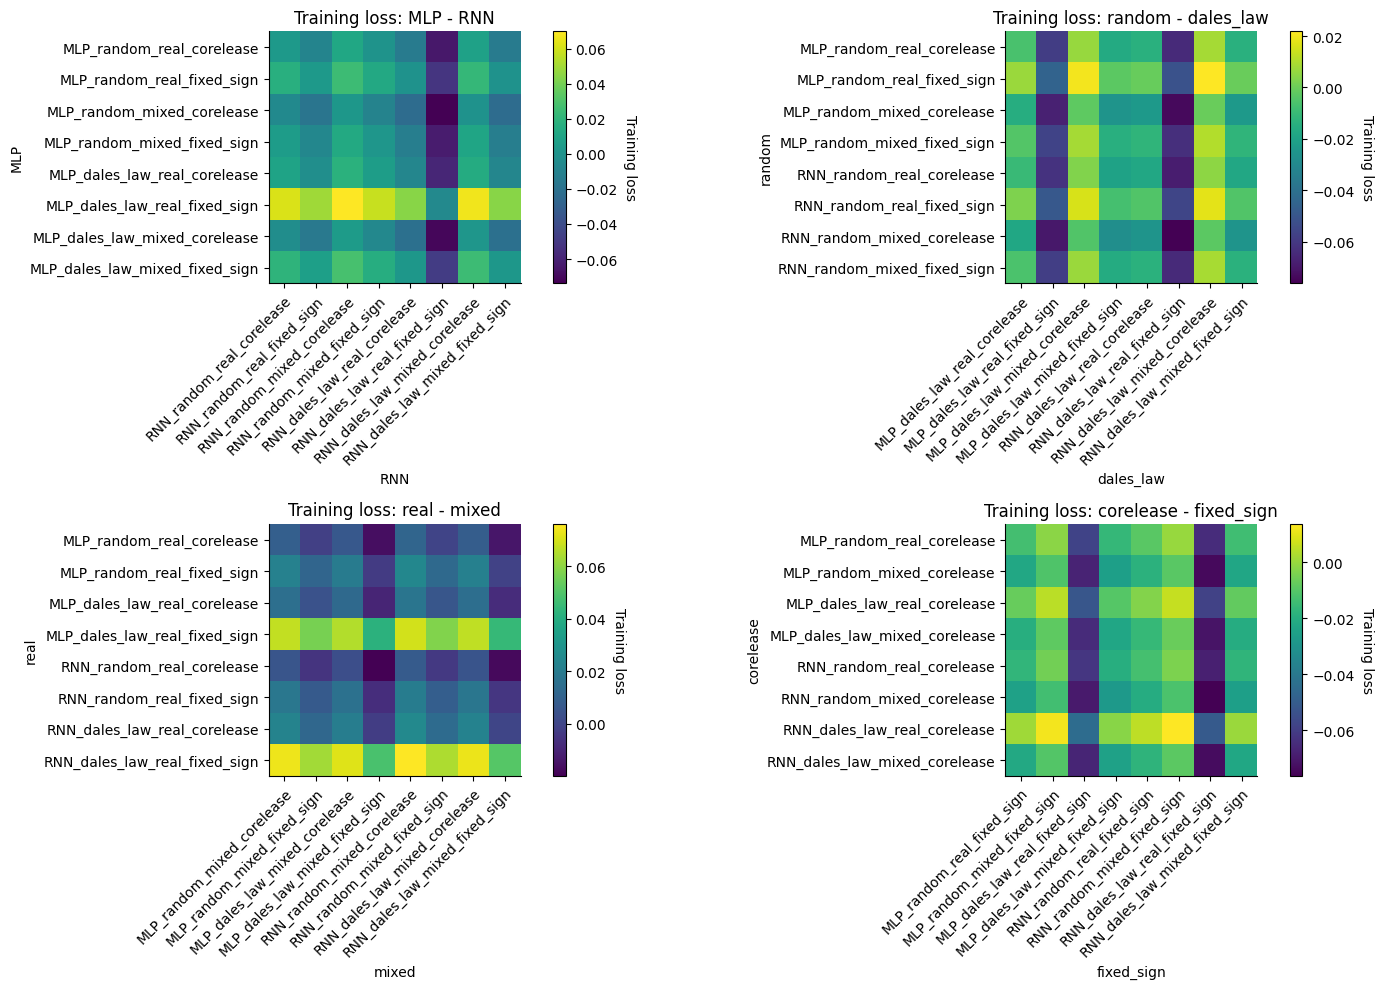

In [ ]:
# Plot heatmaps to plot differences between conditions

fig, axs = plt.subplots(2,2,figsize=(15, 10))

conditions = [LHb_network, initialization, network_struct, update_methods]

for i, condition in enumerate(conditions):
    # Choose network that satisfies condition
    cond_1 = condition[0]
    cond_1_networks = [network for network in training_loss_summary if cond_1 in network]
    cond_2 = condition[1]
    cond_2_networks = [network for network in training_loss_summary if cond_2 in network]

    x = np.array([np.mean(training_loss_summary[network],axis=1) for network in cond_1_networks]).squeeze()
    y = np.array([np.mean(training_loss_summary[network],axis=1) for network in cond_2_networks]).squeeze()

    x_reshape = x[:,np.newaxis]
    y_reshape = y[np.newaxis,:]
    diff = x_reshape - y_reshape

    # Plot heatmap
    im = axs[i//2,i%2].imshow(diff, cmap='PRGn',vmax=abs(diff).max(), vmin=-abs(diff).max())
    axs[i//2,i%2].set_xticks(np.arange(len(cond_2_networks)))
    axs[i//2,i%2].set_yticks(np.arange(len(cond_1_networks)))
    axs[i//2,i%2].set_xticklabels(cond_2_networks)
    axs[i//2,i%2].set_yticklabels(cond_1_networks)
    axs[i//2,i%2].set_xlabel(cond_2)
    axs[i//2,i%2].set_ylabel(cond_1)
    # Rotate the tick labels and set their alignment.
    plt.setp(axs[i//2,i%2].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Set colorbar
    cbar = axs[i//2,i%2].figure.colorbar(im, ax=axs[i//2,i%2])
    cbar.ax.set_ylabel('Difference', rotation=-90, va="bottom")
    # Set title
    axs[i//2,i%2].set_title('Training loss: '+cond_1+' - '+cond_2)

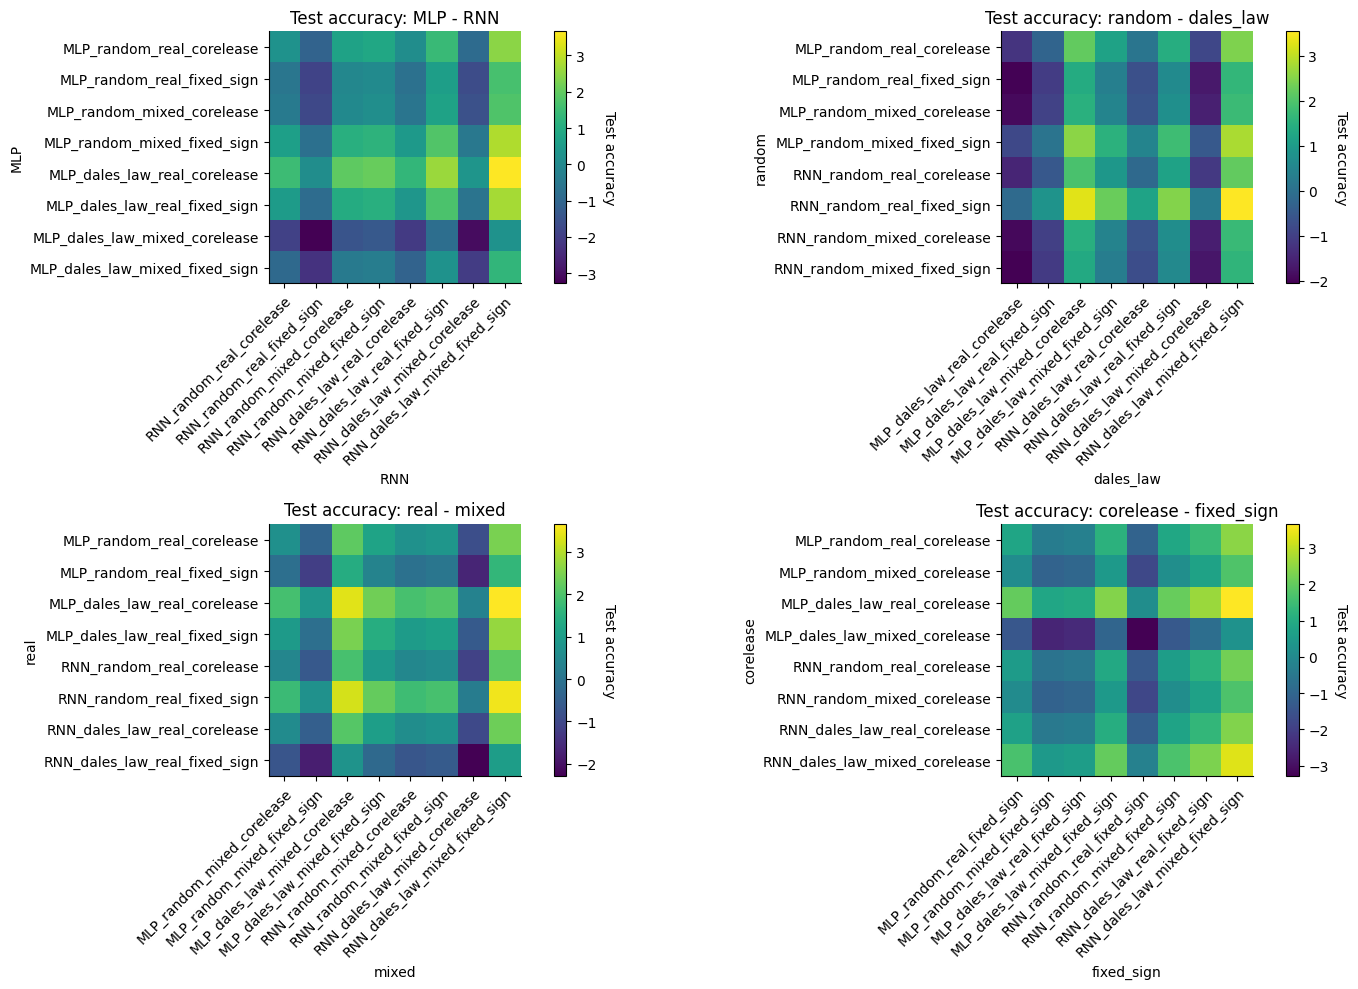

In [ ]:
# Plot heatmaps to plot differences between conditions

fig, axs = plt.subplots(2,2,figsize=(15, 10))

conditions = [LHb_network, initialization, network_struct, update_methods]

for i, condition in enumerate(conditions):
    # Choose network that satisfies condition
    cond_1 = condition[0]
    cond_1_networks = [network for network in training_loss_summary if cond_1 in network]
    cond_2 = condition[1]
    cond_2_networks = [network for network in training_loss_summary if cond_2 in network]

    x = np.array([np.mean(test_accuracy_summary[network],axis=1) for network in cond_1_networks]).squeeze()
    y = np.array([np.mean(test_accuracy_summary[network],axis=1) for network in cond_2_networks]).squeeze()

    x_reshape = x[:,np.newaxis]
    y_reshape = y[np.newaxis,:]
    diff = x_reshape - y_reshape

    # Plot heatmap
    im = axs[i//2,i%2].imshow(diff, cmap='PRGn',vmax=abs(diff).max(), vmin=-abs(diff).max())
    axs[i//2,i%2].set_xticks(np.arange(len(cond_2_networks)))
    axs[i//2,i%2].set_yticks(np.arange(len(cond_1_networks)))
    axs[i//2,i%2].set_xticklabels(cond_2_networks)
    axs[i//2,i%2].set_yticklabels(cond_1_networks)
    axs[i//2,i%2].set_xlabel(cond_2)
    axs[i//2,i%2].set_ylabel(cond_1)
    # Rotate the tick labels and set their alignment.
    plt.setp(axs[i//2,i%2].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Set colorbar
    cbar = axs[i//2,i%2].figure.colorbar(im, ax=axs[i//2,i%2])
    cbar.ax.set_ylabel('Difference', rotation=-90, va="bottom")
    # Set title
    axs[i//2,i%2].set_title('Test accuracy: '+cond_1+' - '+cond_2)

## Old code